## Montreal Python 69 - Tutorial
### Monday Feb 5th 2018
#### Three Methods to Aggregate Subscriber's Interest - Aggregating Data
#### AGENDA:

>      1- Using Python Dictionary
      
>      2- Using Apache Spark - GroupBy Transformation
      
>      3- Using Apache Spark - ReduceBy Transformation
      

## Problem Statment: 
### For Subscribers of an Online Magazine
### Aggregate subscriber's interst/likes for each subscriber - "Aggregate Interest by ID"
### Original Data:

In [1]:
import pandas as pd
pd.set_option('display.max_rows',10)  # change preview settings

fname = './InterestData.csv'
subscrib_data = pd.read_csv(fname, delimiter =';')
subscrib_data

,ID,Interest
0,1001,Sports
1,1001,Techno
2,1002,Auto
3,1002,Food
4,1002,Sports
...,...,...
39,1018,Techno
40,1019,Food
41,1019,Techno
42,1020,Auto


### Output after Aggregating by ID:

In [2]:
import pandas as pd
pd.set_option('display.max_rows',20)  # change preview settings

fname = './InterestAggregated.csv'
subscrib_data = pd.read_csv(fname, delimiter =';')
subscrib_data

,ID,Interest
0,1001,"Sports, Techno"
1,1002,"Auto, Food, Sports, Techno"
2,1003,Food
3,1004,"Auto, Food"
4,1005,"Auto, Food, Techno"
5,1006,"Food, Sports, Techno"
6,1007,"Sports, Techno"
7,1008,"Auto, Techno"
8,1009,Food
9,1010,"Auto, Food"


## RECIPE \#1: Using A Python Dictionary

In [3]:
import csv
from collections import defaultdict  

aggInterest = defaultdict(list) # dictionary that assigns default value as list
header = None

# Read the file into a dictionary
with open('./InterestData.csv','r') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=';')
    header = next(readCSV)  
    for row in readCSV:
        aggInterest[row[0]].append((row[1]))

# Write the dictionary data into the file         
with open('./aggInterest.csv', 'w') as csvfile:         
    writeCSV = csv.writer(csvfile, delimiter=';')
    writeCSV.writerow(header)
    for idd, interest in aggInterest.items():
        writeCSV.writerow((idd,interest))

In [4]:
text_file = open('./aggInterest.csv', 'r')
for line in text_file:
    print(line)

ID;Interest

1001;['Sports', 'Techno']

1002;['Auto', 'Food', 'Sports', 'Techno']

1003;['Food']

1004;['Auto', 'Food']

1005;['Auto', 'Food', 'Techno']

1006;['Food', 'Sports', 'Techno']

1007;['Sports', 'Techno']

1008;['Auto', 'Techno']

1009;['Food']

1010;['Auto', 'Food']

1011;['Food', 'Sport']

1012;['Auto', 'Food', 'Sports', 'Techno']

1013;['Auto']

1014;['Sports']

1015;['Auto', 'Food']

1016;['Auto', 'Food', 'Sports', 'Techno']

1017;['Sports']

1018;['Auto', 'Food', 'Techno']

1019;['Food', 'Techno']

1020;['Auto', 'Food']



In [13]:
with open('./aggInterest.csv', 'w') as csvfile:         
    writeCSV = csv.writer(csvfile, delimiter=';')
    writeCSV.writerow(header)
    for idd, interestLst in aggInterest.items():
        interest = "".join(interestLst)     #join the list into a long string
        writeCSV.writerow((idd,interest))

text_file = open('./aggInterest.csv', 'r')
for line in text_file:
    print(line)

ID;Interest

1001;SportsTechno

1002;AutoFoodSportsTechno

1003;Food

1004;AutoFood

1005;AutoFoodTechno

1006;FoodSportsTechno

1007;SportsTechno

1008;AutoTechno

1009;Food

1010;AutoFood

1011;FoodSport

1012;AutoFoodSportsTechno

1013;Auto

1014;Sports

1015;AutoFood

1016;AutoFoodSportsTechno

1017;Sports

1018;AutoFoodTechno

1019;FoodTechno

1020;AutoFood



In [14]:
from IPython.display import Image
from IPython.core.display import HTML 

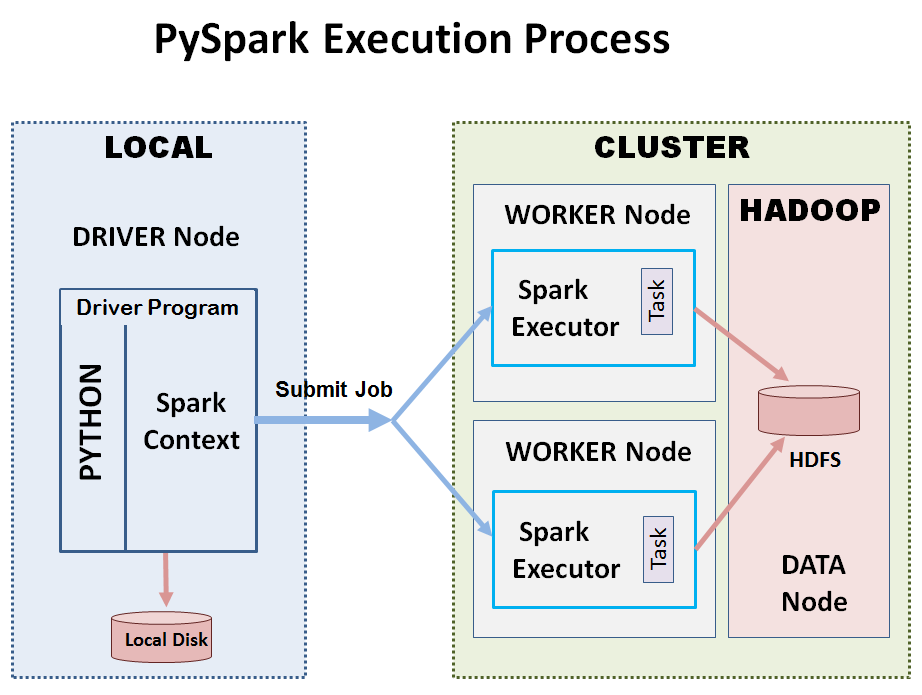

In [7]:
Image(filename = "PySpark_Execution_Process.png", width=750, height=700)

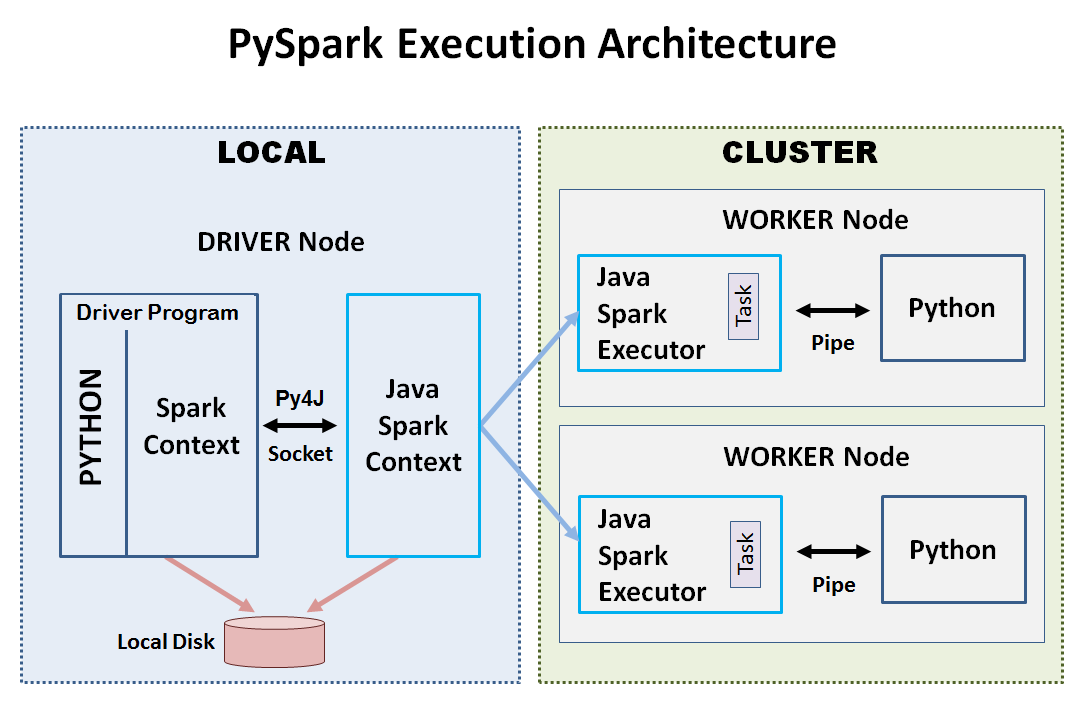

In [8]:
Image(filename ="PySpark_Execution_Architecture.png", width=800, height=750)

## RECIPE \#2: Using Apache Spark - GroupBy Transformation
### 1- Read Subsscriber Interest only data 
### 2- Use groupByKey to merge interest 
### 3- Convert the group-by list into a long string


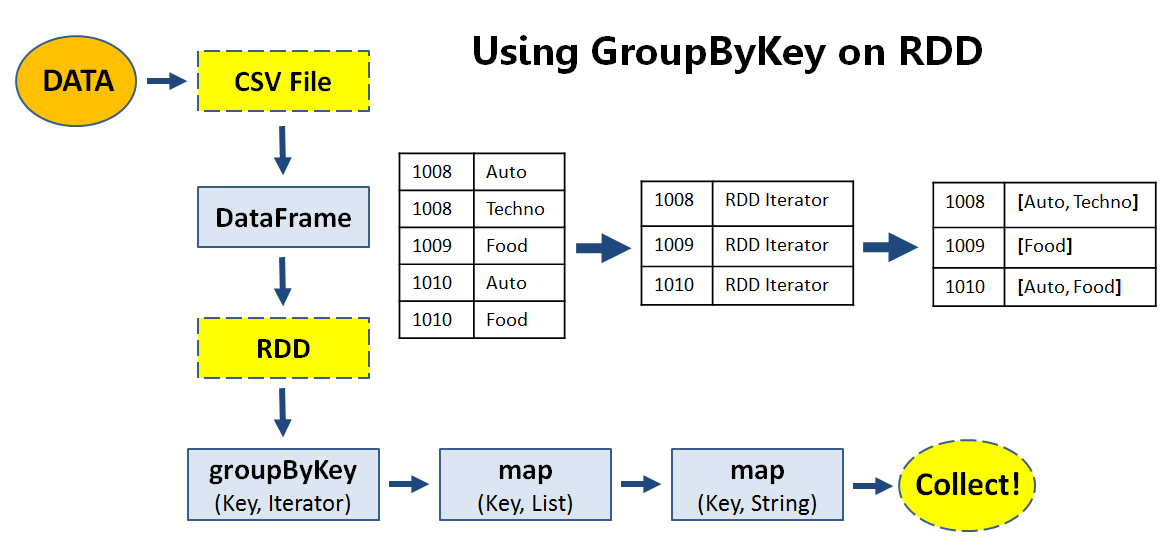

In [9]:
Image(filename ="Using_GroupByKey.png", width=900, height=900)

In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config("spark.master", "local").appName("PythonCSV").getOrCreate()

file = "./InterestData.csv"

# read csv file includes header into a dataframe
dataframe = spark.read.csv(file, sep=";", inferSchema="true", header=True)

df = dataframe.select("ID","Interest")

rdd1 = df.rdd.groupByKey()

#print(rdd1.collect()[0],'\n')
# if we do rdd1.collect() we get [(1001, <pyspark.resultiterable.ResultIterable object), 
#                                 (1002, <pyspark.resultiterable.ResultIterable object), ...]


# to convert groupByKey() iterable into an actual list of strings (interest)
rdd2 = rdd1.map(lambda pair : (pair[0], list(pair[1])))


rdd3 = rdd2.map(lambda pair: (pair[0], (",".join(pair[1])) )) # convert list -> long string

for row in rdd3.collect():
    print(row)

spark.stop()

(1001, 'Sports,Techno')
(1002, 'Auto,Food,Sports,Techno')
(1003, 'Food')
(1004, 'Auto,Food')
(1005, 'Auto,Food,Techno')
(1006, 'Food,Sports,Techno')
(1007, 'Sports,Techno')
(1008, 'Auto,Techno')
(1009, 'Food')
(1010, 'Auto,Food')
(1011, 'Food,Sport')
(1012, 'Auto,Food,Sports,Techno')
(1013, 'Auto')
(1014, 'Sports')
(1015, 'Auto,Food')
(1016, 'Auto,Food,Sports,Techno')
(1017, 'Sports')
(1018, 'Auto,Food,Techno')
(1019, 'Food,Techno')
(1020, 'Auto,Food')


## RECIPE \#3: Using Apache Spark - ReduceBy Transformation
### 1- Read Subsscriber Interest only data 
### 2- Use ReduceByKey to merge interest 
### 3- Convert the interest value list into a long string


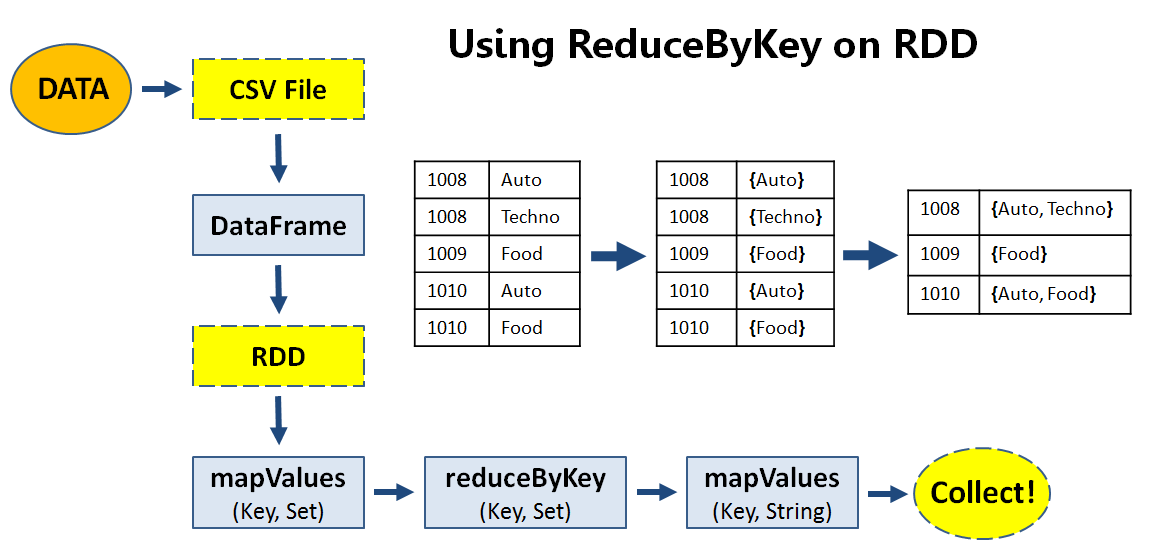

In [11]:
Image(filename ="Using_ReduceByKey.png", width=900, height=900)

In [12]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config("spark.master", "local").appName("PythonCSV").getOrCreate()

file = "./InterestData.csv"

# read csv file includes header into a dataframe
dataframe = spark.read.csv(file, sep=";", inferSchema="true", header=True)

df = dataframe.select("ID","Interest")

# Convert value part -> Set('Interest') using mapValues
# Make a union of all Sets belonging to same key using reduceByKey
rdd1 = df.rdd.mapValues(lambda interest: {interest})\
             .reduceByKey(lambda s1, s2: s1.union(s2))  


rdd3 = rdd1.mapValues(lambda sett: ((",".join(sett)) )) # convert value part -> long string

for row in rdd3.collect():
    print(row)

spark.stop()

(1001, 'Techno,Sports')
(1002, 'Auto,Techno,Sports,Food')
(1003, 'Food')
(1004, 'Auto,Food')
(1005, 'Auto,Techno,Food')
(1006, 'Food,Techno,Sports')
(1007, 'Techno,Sports')
(1008, 'Auto,Techno')
(1009, 'Food')
(1010, 'Auto,Food')
(1011, 'Sport,Food')
(1012, 'Auto,Techno,Sports,Food')
(1013, 'Auto')
(1014, 'Sports')
(1015, 'Auto,Food')
(1016, 'Auto,Techno,Sports,Food')
(1017, 'Sports')
(1018, 'Auto,Techno,Food')
(1019, 'Food,Techno')
(1020, 'Auto,Food')


## NOTES:
### Using reduceByKey is better than GroupBy because all processing happens inside Spark server where as in GroupByKey all prcessing happens in pyspark driver at client side.

### Also using Set {} in reduceByKey is better because it eleminate duplicate in (ID,Interest) pairs if there are any in InterestData.csv file
